This notebook contains:
1. Fixation analysis with respect to different fixation types;
2. Intraclass Correlation Coefficient (consistancy between recordings of the same participant)
3. Cumulative distribution function plots;
4. Correlational analysis
5. Box-plots of fixation counts and durations.

### 0. Import statements & helper functions ###

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import scipy.stats as stats
import pingouin as pg #ICC
from scipy.stats import median_abs_deviation

In [2]:
## function for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a df to include only rows where the timestamp falls within a given intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]

### Main part (loading files and making dataframes) ###

In [3]:
# where all participant folders are located
base_path = "/Users/alina/Downloads/Thesis/raw/"

fixation_analysis = [] # a list to keep general information

all_durations = [] # to keep all durations

participant_cdf_data = defaultdict(lambda: defaultdict(list)) # initiating a nested dictionary (participant + fixation type) to plot CDF for 2 recordings combined

# loading files for each recording based on how they are organised on my computer
for participant_folder in os.listdir(base_path):
    if participant_folder.startswith("Participant"):
        participant_number = participant_folder.split()[-1]
        participant_id = f"P{participant_number}"
        folder_path = os.path.join(base_path, participant_folder)

        for recording_folder in os.listdir(folder_path):
            if recording_folder.startswith(f"P{participant_number}_"):
                recording_number = recording_folder.split('_')[-1]
                recording_path = os.path.join(folder_path, recording_folder)

                try:
                    files = {
                        "fixations_on_everything": os.path.join(recording_path, f"fixations_on_everything_{participant_number}_{recording_number}.csv"), #categorised fixations
                        "world_timestamps": os.path.join(recording_path, "world_timestamps.csv"), #timestamps for video frames from Pupil Cloud
                        "detections": os.path.join(recording_path, f"detections_{participant_number}_{recording_number}.csv"), # yolo detections
                        "face_detections": os.path.join(recording_path, "face_detections.csv"), # facemapper detections
                        "events": os.path.join(recording_path, f"events.csv") #events to clean data
                    }
                    data = {name: pd.read_csv(file) for name, file in files.items()}

                    ### filtering all necessery files

                    # using events file to filter the data to only experiment-relevant
                    events_df = data["events"].sort_values("timestamp [ns]")
                    A_events, B_events, C_events, D_events = (events_df[events_df["name"] == event] for event in ['A', 'B', 'C', 'D'])
                    intervals = [
                        (A_events["timestamp [ns]"].max(), B_events["timestamp [ns]"].min()),
                        (B_events["timestamp [ns]"].max(), C_events["timestamp [ns]"].min()),
                        (C_events["timestamp [ns]"].max(), D_events["timestamp [ns]"].min())
                    ]

                    face_detections_df = data["face_detections"]
                    face_detections_df = filter_by_intervals(data["face_detections"], intervals)

                    video_df = pd.DataFrame({
                        "Frame": np.arange(len(data["world_timestamps"])),
                        "timestamp [ns]": data["world_timestamps"]['timestamp [ns]'],
                    })
                    filtered_frames = video_df['Frame']
                    detections_df = data["detections"][data["detections"]['Frame'].isin(filtered_frames)]

                    categorised_fixations_df = data["fixations_on_everything"]
                    categorised_fixations_df = filter_by_intervals(data["fixations_on_everything"], intervals)

                    fixation_types = ['face', 'body', 'background']

                    # making a list of all fixation durations for all recordings based on type of fixations (to make a box-plot later)
                    for fixation_type in fixation_types:
                        durations = categorised_fixations_df[categorised_fixations_df['type'] == fixation_type]['duration [ms]']
                        for duration in durations:
                            all_durations.append({
                                                'Participant': participant_number,
                                                'Fixation Type': fixation_type,
                                                'Duration': duration
                                                  })
                            
                    # convert to df
                    durations_df = pd.DataFrame(all_durations)


                    ### steps to plot CDF for each articipant and fixation type later

                    # normalising time for better generazability and combining 2 recordings
                    min_ts = categorised_fixations_df['timestamp [ns]'].min()
                    max_ts = categorised_fixations_df['timestamp [ns]'].max()
                    categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)

                    if participant_id not in participant_cdf_data: # initializes a dictionary for a participant with keys: face, body, background
                        participant_cdf_data[participant_id] = {ft: [] for ft in ['face', 'body', 'background']}

                    # grouping for fixation types
                    for fixation_type, group in categorised_fixations_df.groupby('type'): #grouping fixations by type
                        group = group.sort_values(by='timestamp [ns]')
                        group['cumulative_count'] = range(1, len(group) + 1) # calculate count for each type
                        group['cumulative_probability'] = group['cumulative_count'] / len(group) # CDF
                        
                        # grouping for participant and store CDF data
                        participant_cdf_data[participant_id][fixation_type].append(
                            group[['normalised_time', 'cumulative_probability']].reset_index(drop=True)
                        )


                    ### making a df with all relevant info for each recording for further analysis
                    fixation_counts = {f"{ft} fixations": len(categorised_fixations_df[categorised_fixations_df['type'] == ft]) for ft in fixation_types}
                    total_fixations = sum(fixation_counts.values())
                
                    fixation_analysis.append({
                        "Participant": participant_number,
                        "Recording": recording_number,
                        **fixation_counts,
                        "Total fixations": total_fixations,
                        "Face detections": len(face_detections_df),
                        "Body detections": len(detections_df),
                    })

                # error if some files weren't found/loaded
                except Exception as e:
                    print(f"Error with recording {participant_number}_{recording_number}: {e}")

# a df with variables describing fixations per recording
fixation_analysis_df = pd.DataFrame(fixation_analysis)

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/444002347.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/444002347.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorised_fixations_df['normalised_time'] = (categorised_fixations_df['timestamp [ns]'] - min_ts) / (max_ts - min_ts)
/var/folders/rl/

In [ ]:
"""save_path = os.path.join(base_path, 'Fixations_stats_all_recordings.csv')
fixation_analysis_df.to_csv(save_path, index=False) """

#fixation_analysis_df.info()

In [11]:
## combing per participant ad adding facial landmarks information 

# sum over both recordings per participant
agg_dict = {
    **{f"{ft} fixations": "sum" for ft in fixation_types},
    "Total fixations": "sum",
    "Face detections": "sum",
    "Body detections": "sum",
}
participant_fixations_summary = fixation_analysis_df.groupby("Participant").agg(agg_dict).reset_index()

# add proportion columns
for ft in fixation_types:
    col_fix = f"{ft} fixations"
    participant_fixations_summary[f'proportion {ft}'] = participant_fixations_summary[col_fix] / participant_fixations_summary["Total fixations"]

# add median fixation durations per type
median_durations = durations_df.groupby(['Participant', 'Fixation Type'])['Duration'].median().reset_index()
median_durations = median_durations.pivot(index='Participant', columns='Fixation Type', values='Duration').reset_index()
median_durations.rename(columns=lambda x: f"median duration {x}" if x != 'Participant' else x, inplace=True)
participant_fixations_summary = participant_fixations_summary.merge(median_durations, on='Participant', how='left')

# load facial landmarks and fix participant format
landmarks_df = pd.read_csv("/Users/alina/Downloads/Thesis/raw/face_landmarks_all_participants.csv")
landmarks_df['Participant'] = landmarks_df['Participant'].astype(str).replace("9", "09")

# median durations per face AOI
facial_aois = ['left_eye', 'right_eye', 'nose', 'mouth']
duration_facial_landmarks = landmarks_df[landmarks_df['assigned_aoi'].isin(facial_aois)] \
    .groupby(['Participant', 'assigned_aoi'])['duration (ms)'].mean().reset_index()

median_duration_facial_landmarks_df = duration_facial_landmarks.pivot_table(
    index='Participant',
    columns='assigned_aoi',
    values='duration (ms)',
    aggfunc='median'
).reset_index()

median_duration_facial_landmarks_df = median_duration_facial_landmarks_df.rename(
    columns=lambda x: f"median duration {x}" if x != 'Participant' else x
)

participant_fixations_summary = participant_fixations_summary.merge(
    median_duration_facial_landmarks_df, on='Participant', how='left'
)

# face AOI fixation counts
aoi_counts = landmarks_df[landmarks_df['assigned_aoi'].isin(facial_aois)].pivot_table(
    index='Participant',
    columns='assigned_aoi',
    values='fixation_id',
    aggfunc='count',
    fill_value=0
).reset_index()

participant_fixations_summary = participant_fixations_summary.merge(
    aoi_counts, on='Participant', how='left'
)

# proportion of each face AOI relative to total face AOI fixations
# sum left_eye + right_eye + nose + mouth
total_face_aoi_fixations = participant_fixations_summary[facial_aois].sum(axis=1)

# add proportion columns
for aoi in facial_aois:
    participant_fixations_summary[f'proportion {aoi}'] = participant_fixations_summary[aoi] / total_face_aoi_fixations

participant_fixations_summary = participant_fixations_summary[[
    'Participant',
    "Face detections", "Body detections",
    *[f'proportion {ft}' for ft in fixation_types],
    *[f'median duration {ft}' for ft in fixation_types],
    *[f'median duration {aoi}' for aoi in facial_aois],
    *[f'proportion {aoi}' for aoi in facial_aois],
    *{f"{ft} fixations": "sum" for ft in fixation_types}
]]

participant_fixations_summary.to_csv("Participants fixations summary.csv", index=False)
participant_fixations_summary.head()

,Participant,Face detections,Body detections,proportion face,proportion body,proportion background,median duration face,median duration body,median duration background,median duration left_eye,median duration right_eye,median duration nose,median duration mouth,proportion left_eye,proportion right_eye,proportion nose,proportion mouth,face fixations,body fixations,background fixations
0,09,281420,1584532,0.031250,0.367742,0.601008,262.7500,235.0,230.250,389.700000,360.346939,359.734375,428.064516,0.255319,0.208511,0.272340,0.263830,366,4307,7039
1,10,197856,1431774,0.001741,0.186325,0.811934,290.2590,285.0,260.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1605,6994
2,11,188260,1390940,0.009522,0.287338,0.703141,192.6875,205.0,200.128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,3742,9157
3,12,170171,1281786,0.016770,0.260662,0.722568,227.6875,195.0,200.135,239.800000,247.522727,385.128205,283.666667,0.231788,0.291391,0.258278,0.218543,186,2891,8014
4,13,330536,1584314,0.015284,0.328384,0.656332,247.6875,295.0,305.250,189.666667,339.200000,239.166667,230.000000,0.416667,0.277778,0.166667,0.138889,140,3008,6012


#### Duration of Facial Landmarks

In [12]:
duration_facial_landmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Participant    48 non-null     object 
 1   assigned_aoi   48 non-null     object 
 2   duration (ms)  48 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/357737989.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/357737989.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=11)


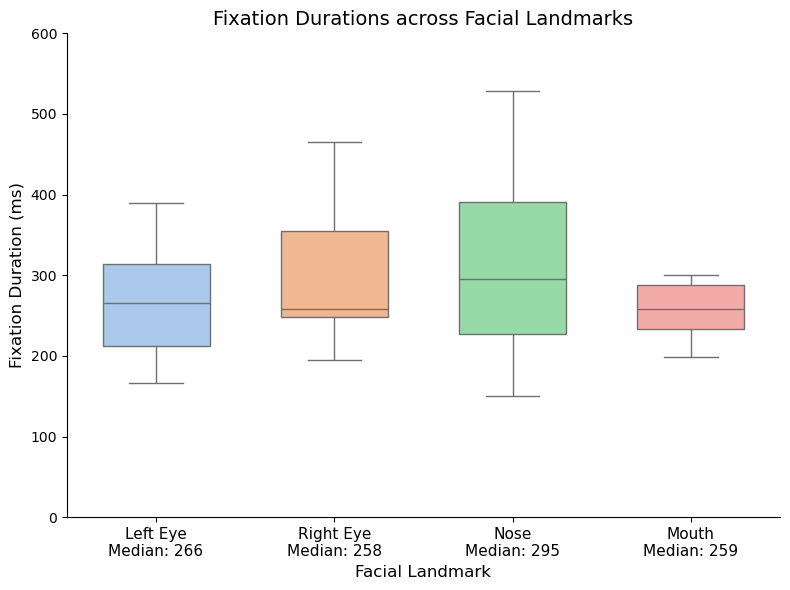

In [ ]:
landmarks = ['left_eye', 'right_eye', 'nose', 'mouth']

group_medians = duration_facial_landmarks.groupby('assigned_aoi')['duration (ms)'].median()
group_mad = duration_facial_landmarks.groupby('assigned_aoi')['duration (ms)'].apply(lambda x: (x - x.median()).abs().median())

# new x-axis labels with medians
new_labels = [
    f"{aoi.replace('_', ' ').title()}\nMedian: {group_medians[aoi]:.0f}"
    for aoi in landmarks
]

plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=duration_facial_landmarks,
    x='assigned_aoi',
    y='duration (ms)',
    order=landmarks,
    palette='pastel',
    showmeans=False,
    showfliers=False,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

ax.set_xticklabels(new_labels, fontsize=11)
ax.set_title("Fixation Durations across Facial Landmarks", fontsize=14)
ax.set_ylabel("Fixation Duration (ms)", fontsize=12)
ax.set_xlabel("Facial Landmark", fontsize=12)
ax.set_ylim(0, 600)

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
landmark_duration_stats = pd.DataFrame({
    'Median': group_medians,
    'MAD': group_mad
})
landmark_duration_stats 

,Median,MAD
assigned_aoi,,
left_eye,266.000000,61.500000
mouth,258.667647,26.833333
nose,295.041667,92.371795
right_eye,258.301754,58.668421


### ICC - Consistancy of Fixation Counts within a participant 

0.75–0.90 = Good reliability

0.50–0.75 = Moderate reliability

Negative or near-zero lower CI bounds => the result isn’t stable 

In [32]:
# proportion of each fixation type
fixation_analysis_df['proportion face'] = fixation_analysis_df['face fixations'] / fixation_analysis_df['Total fixations']
fixation_analysis_df['proportion body'] = fixation_analysis_df['body fixations'] / fixation_analysis_df['Total fixations']
fixation_analysis_df['proportion background'] = fixation_analysis_df['background fixations'] / fixation_analysis_df['Total fixations']

In [ ]:
### Intraclass Correlation Coefficient

icc_results = []

for fixation_type in fixation_types:
    # Prepare a dataframe with necessary columns for ICC calculation
    df_icc = fixation_analysis_df[['Participant', 'Recording', f'proportion {fixation_type}']].rename(
        columns={f'proportion {fixation_type}': 'proportion'}
    )
    
    # Calculate ICCs (all types)
    icc = pg.intraclass_corr(data=df_icc,
                             targets='Participant',
                             raters='Recording',
                             ratings='proportion')
    
    # Filter for ICC3 (ICC(3,1))
    icc3 = icc[icc['Type'] == 'ICC3']
    
    # There might be multiple rows for ICC3 (depending on exact pg output), generally one row is expected
    # Take the first match just in case
    icc_row = icc3.iloc[0]
    
    # Append to results list as dict
    icc_results.append({
        'Fixation Type': fixation_type,
        'ICC(3,1)': icc_row['ICC'],
        'CI 95% Lower': icc_row['CI95%'][0],  # CI95% is a tuple/list like (lower, upper)
        'CI 95% Upper': icc_row['CI95%'][1]
    })

# Convert results list to dataframe
icc_summary_df = pd.DataFrame(icc_results)

# Display nicely
print("\nIntraclass Correlation Coefficients (ICC3) for Fixation Proportions by Participant:")
print(icc_summary_df)

# Optionally save to CSV
icc_summary_df.to_csv('icc_summary_fixation_proportions.csv', index=False)


Intraclass Correlation Coefficients (ICC3) for Fixation Proportions by Participant:
  Fixation Type  ICC(3,1)  CI 95% Lower  CI 95% Upper
0          face  0.686290          0.38          0.86
1          body  0.599932          0.25          0.81
2    background  0.609874          0.26          0.82


Differences are much smaller when proportion is from detections and not total fixations.

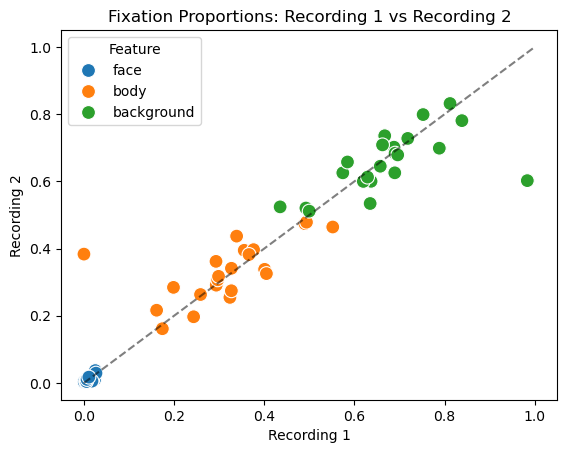

In [41]:
## plot and print of residuals (differences) of each fixation type proportion

types = ["face", "body", "background"]

differences = []

for participant, group in fixation_analysis_df.groupby("Participant"):
    if len(group) == 2:
        for type in types:
            # get values for the two recordings
            vals = group[f"proportion {type}"].values
            
            differences.append({
                "Participant": participant,
                "Feature": type,
                "Recording 1": vals[0],
                "Recording 2": vals[1],
                "Absolute Difference": abs(vals[0] - vals[1])
            })

types_diff_df = pd.DataFrame(differences)
#print(types_diff_df)

sns.scatterplot(
    data=types_diff_df,
    x="Recording 1",
    y="Recording 2",
    hue="Feature",
    #style="Participant",
    s=100
)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # line if there were no differences
plt.title("Fixation Proportions: Recording 1 vs Recording 2")
plt.xlabel("Recording 1")
plt.ylabel("Recording 2")
plt.show()


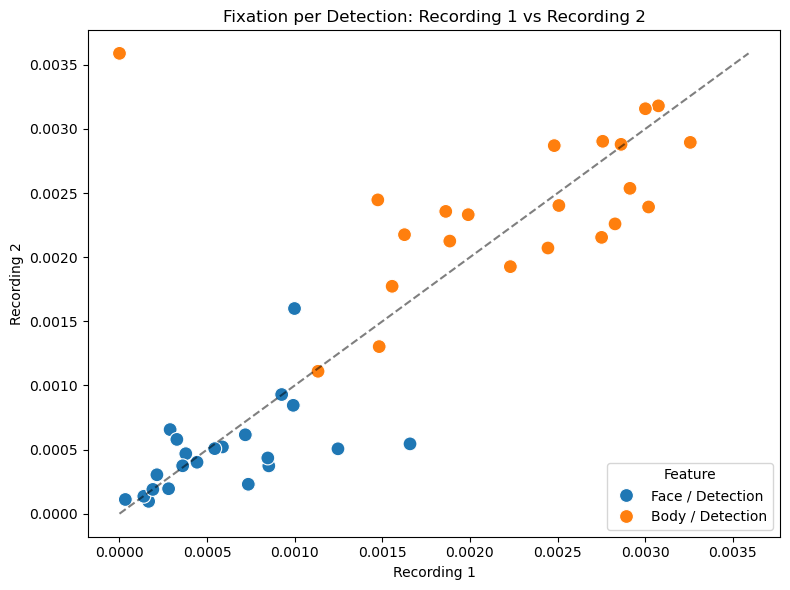

In [ ]:
types = ["face", "body"]

differences = []

for participant, group in fixation_analysis_df.groupby("Participant"):
    if len(group) == 2:
        for type in types:
            col = f"{type}_fix_per_detection"
            vals = group[col].values
            
            differences.append({
                "Participant": participant,
                "Feature": f"{type.capitalize()} / Detection",
                "Recording 1": vals[0],
                "Recording 2": vals[1],
                "Absolute Difference": abs(vals[0] - vals[1])
            })

det_controlled_df = pd.DataFrame(differences)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=det_controlled_df,
    x="Recording 1",
    y="Recording 2",
    hue="Feature",
    s=100
)

# Diagonal line (perfect match line)
min_val = min(det_controlled_df["Recording 1"].min(), det_controlled_df["Recording 2"].min())
max_val = max(det_controlled_df["Recording 1"].max(), det_controlled_df["Recording 2"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

plt.title("Fixation per Detection: Recording 1 vs Recording 2")
plt.xlabel("Recording 1")
plt.ylabel("Recording 2")
plt.tight_layout()
plt.show()


### Plots (CDF) ###

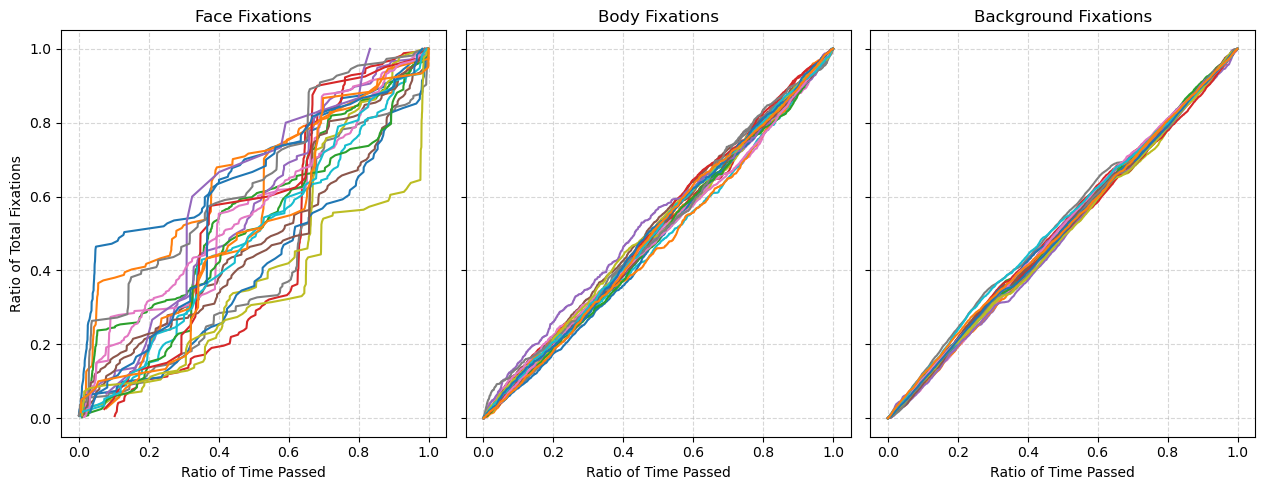

In [43]:
# combine and compute merged CDFs per participant
merged_participant_cdf = defaultdict(dict)

for participant_id, fixation_types in participant_cdf_data.items():
    for fixation_type, dfs in fixation_types.items():
        combined_df = pd.concat(dfs, ignore_index=True).sort_values(by='normalised_time').reset_index(drop=True)
        combined_df['cumulative_count'] = range(1, len(combined_df) + 1)
        combined_df['cumulative_probability'] = combined_df['cumulative_count'] / len(combined_df)
        merged_participant_cdf[fixation_type][participant_id] = combined_df[['normalised_time', 'cumulative_probability']]

# to plot all fixation types side by side
fixation_types = list(merged_participant_cdf.keys())

fig, axes = plt.subplots(1, len(fixation_types), figsize=(5 * len(fixation_types), 5), sharey=True)

for ax, fixation_type in zip(axes, fixation_types):
    participant_dfs = merged_participant_cdf[fixation_type]
    for participant_id, df in participant_dfs.items():
        ax.plot(df['normalised_time'], df['cumulative_probability'], label=f'{participant_id}')
    ax.set_title(f'{fixation_type.capitalize()} Fixations')
    ax.set_xlabel('Ratio of Time Passed')
    ax.grid(True, linestyle='--', alpha=0.5)

axes[0].set_ylabel('Ratio of Total Fixations')

# a legend on the right outside the plots
handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Participants', bbox_to_anchor=(0.85, 0.7), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # better visually
plt.show()


In [44]:
# Sum fixations across all participants
total_face = participant_fixations_summary['face fixations'].sum()
total_body = participant_fixations_summary['body fixations'].sum()
total_background = participant_fixations_summary['background fixations'].sum()

# Calculate total fixations
total_fixations = total_face + total_body + total_background

# Calculate percentages
face_pct = total_face * 100 / total_fixations
body_pct = total_body * 100 / total_fixations
background_pct = total_background * 100 / total_fixations

print(f"Total percentage of face fixations for all participant is {face_pct}.")
print(f"Total percentage of body fixations for all participant is {body_pct}.")
print(f"Total percentage of background fixations for all participant is {background_pct}.")

'''# Create the pie chart
labels = ['Face', 'Body', 'Background']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
percentages = [face_pct, body_pct, background_pct]

plt.figure(figsize=(5, 5))
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Overall Fixation Distribution (All Participants)')
plt.axis('equal')
plt.show()'''


Total percentage of face fixations for all participant is 1.2472404262346377.
Total percentage of body fixations for all participant is 32.14186382046691.
Total percentage of background fixations for all participant is 66.61089575329845.


"# Create the pie chart\nlabels = ['Face', 'Body', 'Background']\ncolors = ['#1f77b4', '#ff7f0e', '#2ca02c']\npercentages = [face_pct, body_pct, background_pct]\n\nplt.figure(figsize=(5, 5))\nplt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)\nplt.title('Overall Fixation Distribution (All Participants)')\nplt.axis('equal')\nplt.show()"

### Descriptive and Correlative stats ###

I first calculate the fixation count on each facial landmark and mean duration and then merge this dataframe with the face landmarks count dataframe. 

1. Duration metrics strongly correlate between different object categories.
2. Number of face and body detections moderately correlate with the number of face and body detections.
3. Face and body fixation number strongly correlate 
4. As well face and body detection number (which shows that the algorithms work).
5. Mouth correlates with body fixations
other add

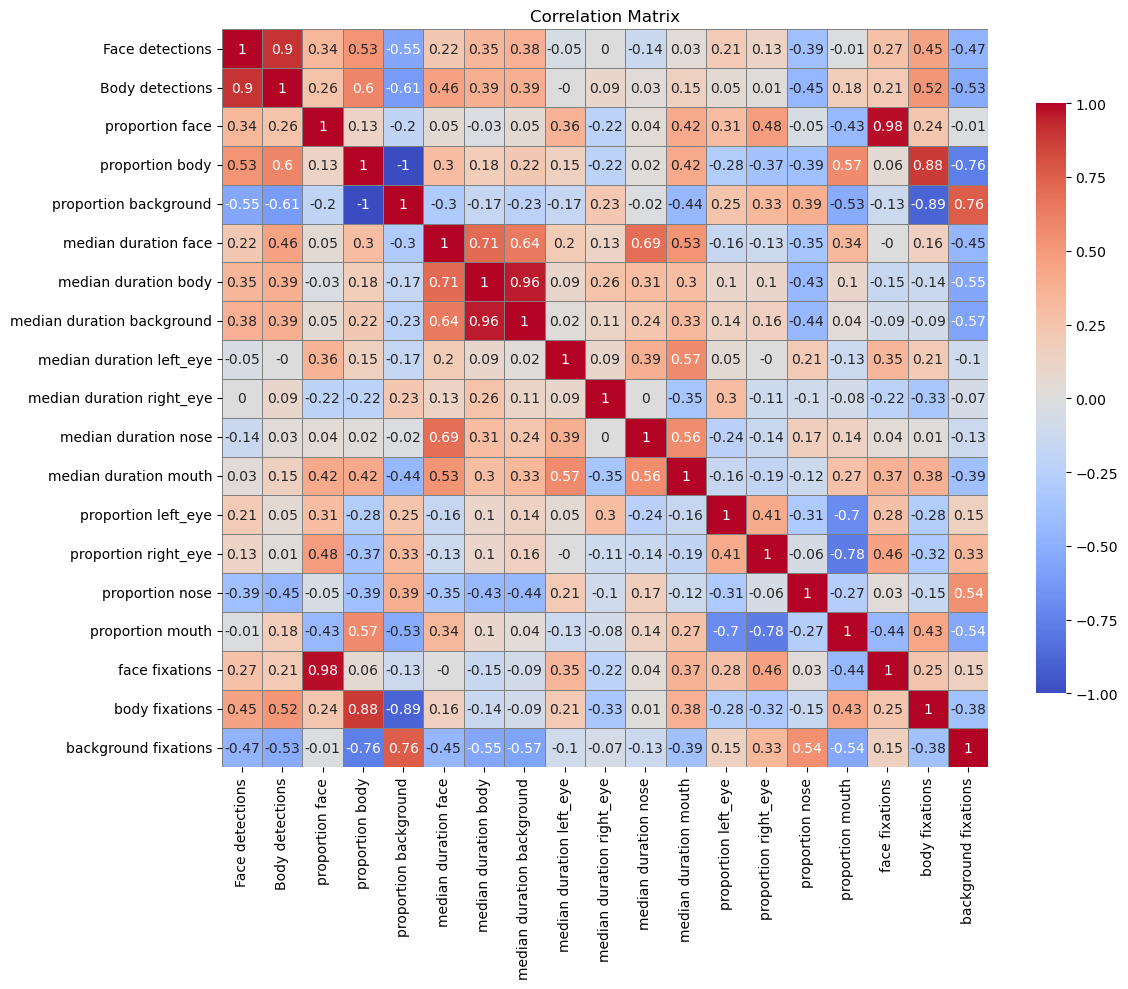

In [5]:
cols_to_exclude = ['Participant']

# a new df excluding those columns for correlations
df_corr_small = participant_fixations_summary.drop(columns=cols_to_exclude)
corr_matrix = df_corr_small.corr(method='pearson').round(2) #note correlation type

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix ,               
    annot=True,            
    cmap='coolwarm',       
    vmin=-1, vmax=1,            
    center=0,                    
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### PLots - fixation counts and durations ###

In [6]:
## fixation counts mean and standard deviation per category for all participants

# making a df with descriptive statistics
describe_stats = participant_fixations_summary.describe()

# getting mean and st deviation from that df
mean_face_fix_amount = describe_stats.loc['mean', 'face fixations']
mean_body_fix_amount = describe_stats.loc['mean', 'body fixations']
mean_background_fix_amount = describe_stats.loc['mean', 'background fixations']

std_face = describe_stats.loc['std', 'face fixations']
std_body_fix_amount = describe_stats.loc['std', 'body fixations']
std_background_fix_amount = describe_stats.loc['std', 'background fixations']

# new df with the necessery columns
summary_df = pd.DataFrame({
    'Category': ['Face', 'Body', 'Background'],
    'Mean': [mean_face_fix_amount, mean_body_fix_amount, mean_background_fix_amount],
    'Std Dev': [std_face, std_body_fix_amount, std_background_fix_amount],
})
summary_df = summary_df.round(2)
display(summary_df)

,Category,Mean,Std Dev
0,Face,130.45,81.84
1,Body,3361.86,953.78
2,Background,6967.14,1628.89


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/330304465.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/330304465.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


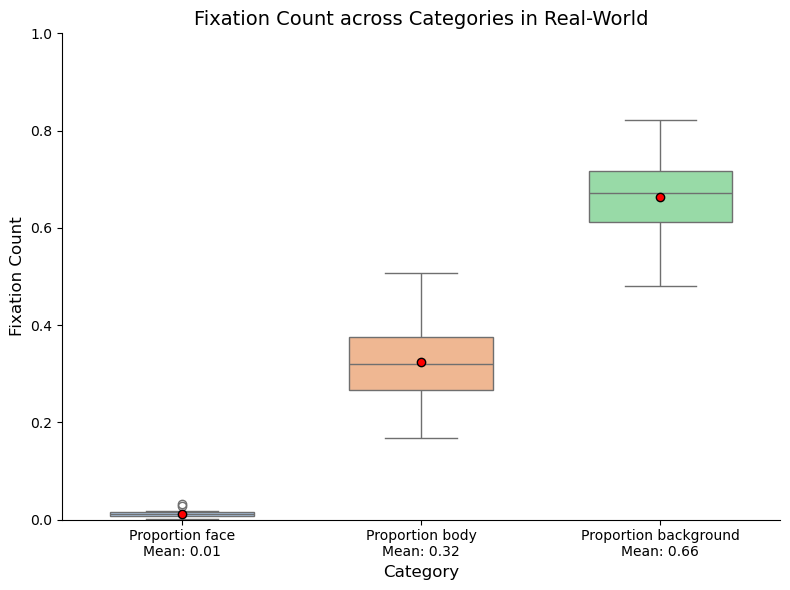

In [7]:
### Fixation count per category box plot


# getting fixation count columns and participant number
fixation_cols = ['proportion face', 'proportion body', 'proportion background']
fixation_data = participant_fixations_summary[['Participant'] + fixation_cols]

# reshaping df to a long format
fixation_melted = fixation_data.melt(id_vars='Participant',
                                     value_vars=fixation_cols,
                                     var_name='Category',
                                     value_name='Fixation Count')

# making category names
fixation_melted['Category'] = fixation_melted['Category'].str.replace(' fixations', '').str.capitalize()

# defining order of categories based on fixation_cols
category_order = [col.replace(' fixations', '').capitalize() for col in fixation_cols]

# calculating means
group_means = fixation_melted.groupby('Category')['Fixation Count'].mean()

# making labels with category + mean
new_labels = [f"{cat}\nMean: {group_means[cat]:.2f}" for cat in category_order]

# box-plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=fixation_melted,
    x='Category',
    y='Fixation Count',
    order=category_order,               
    palette='pastel',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

# x-axis tick labels with category + mean
ax.set_xticklabels(new_labels)

ax.set_title("Fixation Count across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Count", fontsize=12)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylim(0,1)  # setting y-axis limits 
sns.despine()
plt.tight_layout()
plt.show()

In [8]:
#### Fixation durations median + median absolute value for all recordings per category

# calculating medians from the df with all durations
group_medians = durations_df.groupby("Fixation Type")["Duration"].median().round(2)

# calculating MAD using predifined function
group_mad = durations_df.groupby("Fixation Type")["Duration"].apply(median_abs_deviation).round(2)

duration_stats = pd.DataFrame({
    'Median': group_medians,
    'MAD': group_mad
})
display(duration_stats)

,Median,MAD
Fixation Type,,
background,235.24,85.12
body,240.00,95.00
face,230.25,90.13


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/3731808631.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_95617/3731808631.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=11)


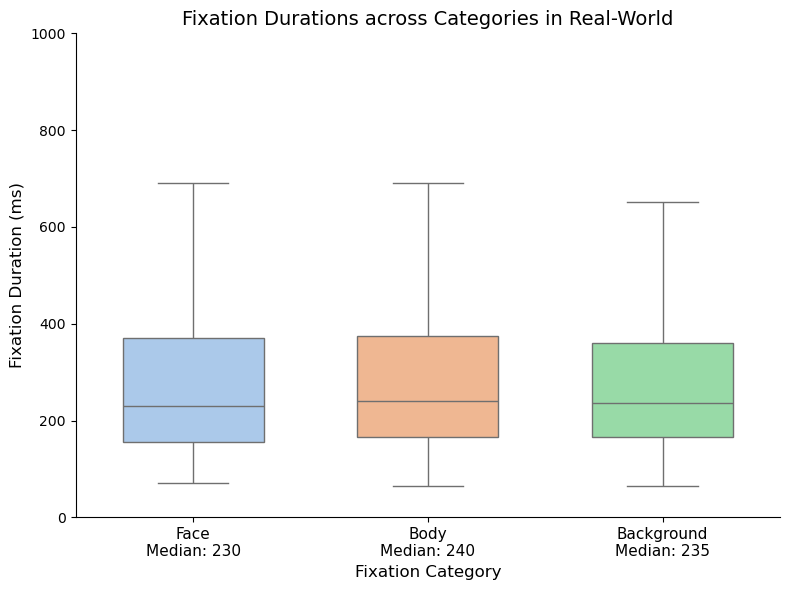

In [9]:
### Fixation durations per category box plot

category_order = ['face', 'body', 'background'] # so it matches

# adding median labels
new_labels = [f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}" for cat in category_order]

# if i want to add MAD to the label
#new_labels = [
    #f"{cat.capitalize()}\nMedian: {group_medians[cat]:.0f}\nMAD: {group_mad[cat]:.1f}"
    #for cat in category_order]

# box-plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=durations_df,
    x="Fixation Type",
    y="Duration",
    order=category_order,
    palette="pastel",
    showmeans=False, # not visualizing mean
    showfliers=False,  # grey outlier circles
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
    width=0.6
)

ax.set_xticklabels(new_labels, fontsize=11)
ax.set_title("Fixation Durations across Categories in Real-World", fontsize=14)
ax.set_ylabel("Fixation Duration (ms)", fontsize=12)
ax.set_ylim(0,1000)  # setting y-axis limits 
ax.set_xlabel("Fixation Category", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()